# Model 3 classifier 

This classifier will determine wheter a review is a `negative`, `neutral` or `positive`.
The approach will be the following: 
1. Import fully labled dataset. 
1. Only take the columns that are necessary and rename unclear column names. 
1. Research the data charecteristics
  * Make a wordcloud of the dataset. 
  * Make a barchart with the balance of the labels. 
1. Preprocess the data.
  * Refactor to all lower case.
  * Stemming with lemmatizer. 
  * Remove stop words.
  * Remove plural.
  * Remove unnecesary words from wordcloud like `app` or something.
1. Create train, validate and test data. (70%, 15%, 15%) 
  * Use train data to train the models with. 
  * Use validate data to validate different models, and cheks who is the best.
  * Use test data to test the validated model. (Model who have won in the above step). 
1. Use different models for classifing the review.


In [3]:
# Helpers. 
import numpy as np # For generating random probabilities to split into train-test dataset
import pandas as pd # For loading data

# Visualizations.
import matplotlib.pyplot as plt # Matplotlib for barcharts.
from wordcloud import WordCloud # WordCloud for visualization of the revies.

# Pre-processing.
import re as regex # Regex support for python.
import nltk # The Natural Language Toolkit. 

from nltk.corpus import stopwords # For removing stopwords
#from nltk.stem.porter import PorterStemmer # For stemming
from nltk.stem import WordNetLemmatizer as Stemmer# For stemming

#from spellchecker import SpellChecker # Fix spelling errors

# Feature engineering.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# ML Algorithms.
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Model analysis.
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quinten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/quinten/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In this section are all the functions that are used in this file. 

In [4]:
def displayWordCloud(label):
  category = ' '.join(list(df[df['label'] == label] ['text']))
  cloud = WordCloud(width = 1000, height = 500).generate(category)
  plt.figure(figsize = (15,8), facecolor = 'k')
  plt.imshow(cloud, interpolation = "bilinear")
  plt.axis("off")
  plt.show()
    
def displayBarChart(column):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  column.value_counts().plot(kind = 'bar', color = '#12f12f', alpha = 0.5, grid = True)
  plt.ylabel('counts')
  plt.title('Distribution of label category')
  plt.xticks(rotation = 'horizontal')
  ax.xaxis.grid(which = "major")
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals = 2), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va ='center')

In [5]:
def model(model, title, trainData, labelTrain, validateData, labelValidate):
    # Train the model.
    model.fit(trainData, labelTrain)
    # Make predections.
    predictions = model.predict(validateData)

    print(title)
    print('Acurracy score: %s\n' % accuracy_score(predictions, labelValidate))
    print(classification_report(labelValidate, predictions))
    
    return model

def svmModel(trainData, labelTrain, validateData, labelValidate):
    svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
    return model(svm, 'SUPPORT VECTOR MACHINE: \n', trainData, labelTrain, validateData, labelValidate)

def bayesModel(trainData, labelTrain, validateData, labelValidate):
    bayesModel = MultinomialNB()
    return model(bayesModel, 'GAUSSIAN NAIVE BAYES: \n', trainData, labelTrain, validateData, labelValidate)

def logisticRegressionModel(trainData, labelTrain, validateData, labelValidate):
    logisticRegressionModel = LogisticRegression(n_jobs = 1, C = 1e5, solver = 'newton-cg', multi_class = 'multinomial')
    return model(logisticRegressionModel, 'LOGISTIC REGRESSION: \n', trainData, labelTrain, validateData, labelValidate)

In [6]:
def cleanReviews(data):
    # The corpus of the reviews, the place where all the pre-processed data will be.
    corpus = []
    customStopwords = {'update', 'app', 'time', 
                   'iphone', 'phone', 'use', 
                   'waze', 'facebook', 'fitbit', 
                   'instagram', 'pinterest', 'whatsapp', 
                   'fitbit', 'myfitnesspal', 'fit', 'traffic', 'food', 'calorie' }

    for i in range(0, len(data)):
        stemmer = Stemmer()
        # Remove punctuation.
        refinedReview = regex.sub('[^a-zA-Z!]', ' ', data[i])
        # To lowercase.
        refinedReview = refinedReview.lower()
        # Split the words, and put every word in an array, this is neccesary for the stemmer. 
        refinedReview = refinedReview.split()
        # Remove custom stopwords.
        refinedReview = [word for word in refinedReview if word not in customStopwords]
        # Stem the review.
        refinedReview = [stemmer.lemmatize(word) for word in refinedReview if not word in set(sw)]
    
        # Concat the array element to each other, to get one review string.
        refinedReview = ' '.join(refinedReview)
      
        refinedReview = refinedReview.split("!")
        refinedReview = ' uitroepteken'.join(refinedReview)
    
        corpus.append(refinedReview)
    
    return corpus

## Data cleaning

First we will import and clean the dataset. We will rename columns, concat the topic and review column. Determine if all the label values are not NaN. 

In [7]:
# Load the data into the dataframe
df = pd.read_excel('data/input/reviews.xlsx')
df.head()

Unnamed: 0  app_name    user_id        user_name                 date  \
0     52505.0  Facebook  246193109     Help is herr  2017-06-21 00:00:00   
1     53247.0  Facebook   43034279        javamdnss  2017-06-16 00:00:00   
2     47018.0  Facebook  496978255              NaN  2017-05-27 00:00:00   
3     41850.0  Facebook  139595037      Gilbertiggy  2017-05-26 00:00:00   
4     41683.0  Facebook  180832062  Princess Lou 24  2017-06-01 00:00:00   

          country version  score                               topic  \
0   United States      97      1        Notifications not showing up   
1   United States      97      1                            Hate it!   
2       Hong Kong      94      1  Useless function n poor experience   
3  United Kingdom      94      1                    To many updates!   
4  United Kingdom      94      1                        Photo albums   

                                              review  \
0  The notification badges are showing up on my i...   
1  Why do they make changes we don't need? Now th...   
2  Story is useless n annoying to user. \nCan't s...   
3  This app is always having an update for someth...   
4  Just spent an hour trying to upload photos and...   

                                                 url  review_id  \
0  https://itunes.apple.com/WebObjects/MZStore.wo...    53163.0   
1  https://itunes.apple.com/WebObjects/MZStore.wo...    53905.0   
2  https://itunes.apple.com/WebObjects/MZStore.wo...    47401.0   
3  https://itunes.apple.com/WebObjects/MZStore.wo...    42233.0   
4  https://itunes.apple.com/WebObjects/MZStore.wo...    42066.0   

  category_final sentiment_final       req_final  
0    requirement         neutral      functional  
1          other   very negative             NaN  
2          other        negative             NaN  
3    requirement        negative      functional  
4    requirement        negative  non-functional

In [8]:
df["topic"] = df["topic"].apply(str)
df["review"] = df["review"].apply(str)

df = df[pd.notnull(df['sentiment_final'])] # Remove empty entries
df = df.reset_index(drop=True) # Reset indexes after removing empty entries

df["sentiment_final"] = df["sentiment_final"].apply(str)
df["sentiment_final"] = df["sentiment_final"].str.lower()

df['text'] = df["topic"] + ' ' + df["review"]

In [9]:
# Select the columns of interest
df = df[["text", "sentiment_final"]]

In [10]:
df = df.rename(columns={"sentiment_final":"label"})

In [11]:
df.loc[df['label'] == 'positve', 'label'] = 'positive'
df.loc[df['label'] == 'postive', 'label'] = 'positive'

df.loc[df['label'] == 'very negative', 'label'] = 'negative'
df.loc[df['label'] == 'very positive', 'label'] = 'positive'

In [12]:
#df['label'] = df['label'].replace(['very negative','negative', "neutral", "positive", "very positive"],np.arange(5))
df['label'] = df['label'].replace(['negative', "neutral", "positive"],np.arange(3))

In [13]:
df.head()

text  label
0  Notifications not showing up The notification ...      1
1  Hate it! Why do they make changes we don't nee...      0
2  Useless function n poor experience Story is us...      0
3  To many updates! This app is always having an ...      0
4  Photo albums Just spent an hour trying to uplo...      0

## Data exploration and visualization

To obtain some more infomration about the data and get a better understanding of the data we'll use some visualizations. First we will make a wordcloud for all the words in the reviews, to determine if we can remove some words from te reviews. 

Then we'll make a bar chart with the distribution of the amount of `positive`, `neutral` or `negative` labels. 

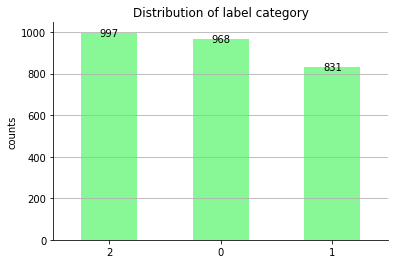

In [15]:
displayBarChart(df['label'])

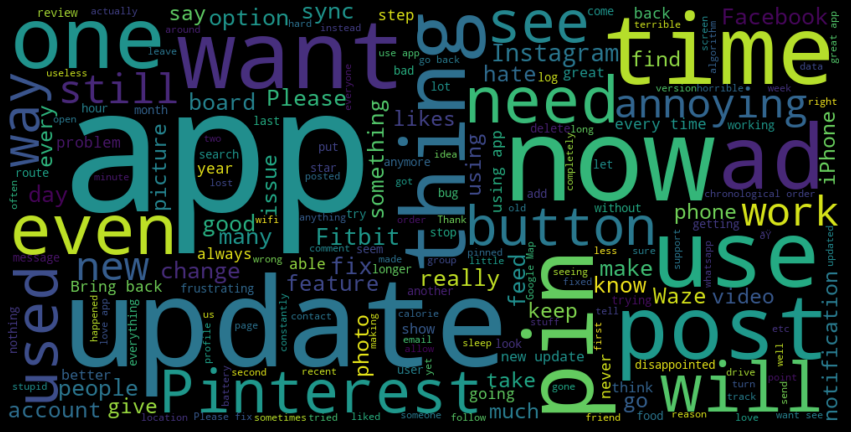

In [16]:
displayWordCloud(0) # Negative wordcloud.

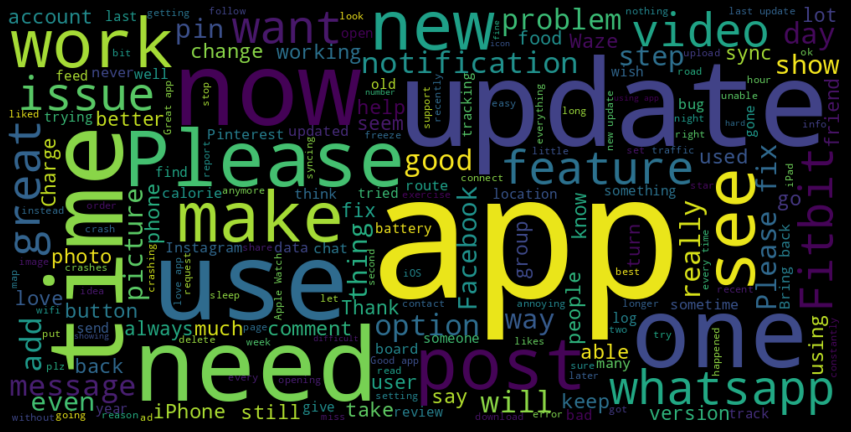

In [33]:
displayWordCloud(1) # Neutral wordcloud.

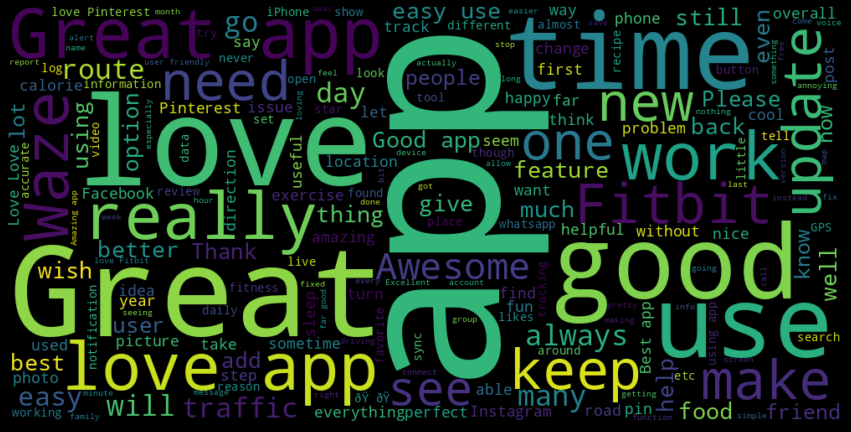

In [34]:
displayWordCloud(2) # Positive wordcloud.

## Pre-processing data

In this section we'll pre-process the data. We will do the following things: 

 * Refactor to all lower case;
   * To make `Get` and `get` the equivelent, no need for upper cases.
 * Remove punctuation marks;
   * The explenation marks will be replace with the word 'uitroepteken' because this will obtain better performance. 
 * Remove plural;
   * Makes it easy to determine the same word as plural. This is done by the porter stemmer.
 * Stemming with lemmatizer; 
   * Refactors `walking` to `walk`. 
 * Remove stop words;
   * Remove natural english stop words. Those words doesn't give away information.
 * Remove unnecesary words from wordcloud. 
   * 'update', 'app', 'time','iphone', 'phone', 'use','waze', 'facebook', 'fitbit', 'instagram', 'pinterest', 'whatsapp','fitbit', 'myfitnesspal', 'fit', 'traffic', 'food', 'calorie'


In [17]:
# Load the english stopwords
sw = stopwords.words("english")

In [19]:
##### Split the text column from label column to easly pre-process.
textColumn = df['text'] 
labelColumn = df['label'].tolist()

In [21]:
corpus = cleanReviews(textColumn)

## Train, validate and test sets

In [22]:
# Split text data into 70, 15, 15 ratio.
textTrain, textTest, textValidate  = np.split(corpus, [int(.7*len(corpus)), int(.85*len(corpus))])

# Split label data into 70, 15, 15 ratio.
labelTrain, labelTest, labelValidate  = np.split(labelColumn, [int(.7*len(labelColumn)), int(.85*len(labelColumn))])

In [23]:
# Training set sneak peak.
textTrain[1:5]

array(['hate it uitroepteken make change need option see recent post  uitroepteken look like going delete way lose people fb',
       'useless function n poor experience story useless n annoying user show new feed n always showing advertisement related football gambling comment selected',
       'many updates uitroepteken always something never get right uitroeptekeni see stuff day suddenly stuff week ado need order stuff pop day',
       'photo album spent hour trying upload photo would work uploading silly come load post every add photo album add sit uploading load separately please sort'],
      dtype='<U1145')

## Feature engineering, TF-IDF Vector

In this section we will abstract from the text some features, and parse the text to number. We'll do this by converting the text to a `Term Frequency-Inverse Document Frequency`. This approach represents the relative importance of a term in a document.

In [24]:
# Create the vectorizer. min_df to get rid of extremly rare words. max_df to get rid of the extremly often used words.
vectorizer = TfidfVectorizer(min_df = 0, max_df = 0.75)
# Use bag of words.
countVectorizer = CountVectorizer()

# Setup training data and test data.
trainDataTFIDF = vectorizer.fit_transform(textTrain).toarray()
validateDataTFIDF = vectorizer.transform(textValidate).toarray()
testDataTFIDF = vectorizer.transform(textTest).toarray()

print('TFIDF \n')
print('Number of features = {}'.format(len(vectorizer.vocabulary_)))
print('Train shape = ', trainDataTFIDF.shape)
print('Validate shape = ', validateDataTFIDF.shape)
print('Test shape = ', testDataTFIDF.shape)

trainDataCV = countVectorizer.fit_transform(textTrain).toarray()
validateDataCV = countVectorizer.transform(textValidate).toarray()
testDataCV = countVectorizer.transform(textTest).toarray()

print('\nCV \n')
print('Number of features = {}'.format(len(countVectorizer.vocabulary_)))
print('Train shape = ', trainDataCV.shape)
print('Validate shape = ', validateDataCV.shape)
print('Test shape = ', testDataCV.shape)

# Take a look at the tfidf matrix. 
frequencyMatrix = pd.DataFrame(trainDataTFIDF, columns = vectorizer.get_feature_names())
frequencyMatrix.head()

'uitroepteken' in vectorizer.get_feature_names()

TFIDF 

Number of features = 4330
Train shape =  (1957, 4330)
Validate shape =  (420, 4330)
Test shape =  (419, 4330)

CV 

Number of features = 4330
Train shape =  (1957, 4330)
Validate shape =  (420, 4330)
Test shape =  (419, 4330)


True

## Modeling

In this section we'll make our machine learning models. We'll fit the models and determine their correctness. 

The models that we are going to validate are: 
  * Naive Bayes Classifier - Multinomial Model
  * Linear Support Vector Machine
  * Logistic Regression

In [25]:
print('------ Bag of words engineering ------')
bayesModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
bayesModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.6023809523809524

              precision    recall  f1-score   support

           0       0.55      0.51      0.53       135
           1       0.55      0.60      0.58       161
           2       0.73      0.70      0.72       124

    accuracy                           0.60       420
   macro avg       0.61      0.61      0.61       420
weighted avg       0.60      0.60      0.60       420

------ TFIDF engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.5642857142857143

              precision    recall  f1-score   support

           0       0.46      0.81      0.59       135
           1       0.70      0.27      0.39       161
           2       0.71      0.67      0.69       124

    accuracy                           0.56       420
   macro avg       0.62      0.59      0.56       420
weighted avg       0.62      0.56      0.54       420



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [30]:
print('------ Bag of words engineering ------')
svmTrainedModel = svmModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
svmModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
SUPPORT VECTOR MACHINE: 

Acurracy score: 0.6523809523809524

              precision    recall  f1-score   support

           0       0.66      0.56      0.61       135
           1       0.60      0.63      0.61       161
           2       0.71      0.78      0.74       124

    accuracy                           0.65       420
   macro avg       0.66      0.66      0.66       420
weighted avg       0.65      0.65      0.65       420

------ TFIDF engineering ------
SUPPORT VECTOR MACHINE: 

Acurracy score: 0.611904761904762

              precision    recall  f1-score   support

           0       0.67      0.56      0.61       135
           1       0.64      0.47      0.54       161
           2       0.56      0.86      0.68       124

    accuracy                           0.61       420
   macro avg       0.62      0.63      0.61       420
weighted avg       0.63      0.61      0.60       420



SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [26]:
print('------ Bag of words engineering ------')
logisticRegressionModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
logisticRegressionModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
LOGISTIC REGRESSION: 

Acurracy score: 0.580952380952381

              precision    recall  f1-score   support

           0       0.59      0.45      0.51       135
           1       0.54      0.59      0.57       161
           2       0.62      0.71      0.66       124

    accuracy                           0.58       420
   macro avg       0.58      0.58      0.58       420
weighted avg       0.58      0.58      0.58       420

------ TFIDF engineering ------
LOGISTIC REGRESSION: 

Acurracy score: 0.6

              precision    recall  f1-score   support

           0       0.60      0.50      0.55       135
           1       0.55      0.62      0.58       161
           2       0.67      0.68      0.67       124

    accuracy                           0.60       420
   macro avg       0.61      0.60      0.60       420
weighted avg       0.60      0.60      0.60       420



LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=1,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

## Final requirements elicitation

According to all the classifers' results, we've chosen to pick the support vector machine for our whole dataset. 

We will load the whole unlabled dataset, and then apply it to our model. We will save the results to a file called `model-3-results` and in the file `combine-results` will the results be combined. 

In [27]:
totaldf = pd.read_csv('data/input/unlabelledDataset.csv') # Read the unlabled dataset.

In [28]:
# Concat the topic and review column to text column.
totaldf['text'] = totaldf['topic'].apply(str) + ' ' + totaldf['review'].apply(str) 

# Generate a corpus and tfidf to fed in the model.
corpus = cleanReviews(totaldf['text'])
tfidf = vectorizer.transform(corpus).toarray()

In [31]:
# Make predictions with the svm. 
labels = svmTrainedModel.predict(tfidf)

# Represent the labels as text ( 0: requirement, 1: bug report, 2: other).
textLabels = np.where(labels == 0, 'negative', 
                np.where(labels == 1, 'neutral', 'positive'))

In [32]:
# Create a new dataframe with the labels and reviews
result = pd.DataFrame(data= {'labels': textLabels, 'reviews': totaldf['text']})
result.head()

labels                                            reviews
0   neutral  Fix this app You continually update this app a...
1   neutral  Really? The new comments section on videos is ...
2  positive                                      Useful Useful
3   neutral  Icons I don't enjoy that the icons on the bott...
4   neutral  Annoying Updated the app despite my gut feelin...

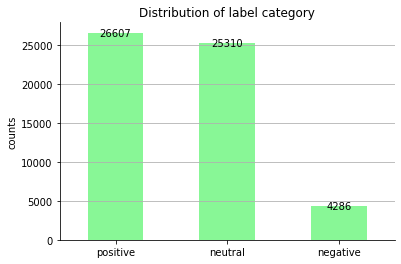

In [33]:
displayBarChart(result['labels'])

In [116]:
# Write result to csv file.
result.to_csv('data/output/model-3-results.csv', index = False)